In [1]:
%load_ext autoreload
%autoreload 2

import networkx as nx
import numpy as np
import pandas as pd
import json
from itertools import chain, product
from collections import defaultdict
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from krxns.cheminfo import expand_paired_cofactors, expand_unpaired_cofactors, MorganFingerPrinter, tanimoto_similarity
print(rdkit.__version__)

2024.03.5


In [2]:
# Load known reaction data

with open("../data/sprhea_240310_v3_mapped.json", 'r') as f:
    known_reactions = json.load(f)

known_reactions = {int(k): v for k,v in known_reactions.items()}

# Remove reverses
rids = set()
for k, v in known_reactions.items():
    rids.add(tuple(sorted([k, v['reverse']])))

keepers = [elt[0] for elt in rids]

known_reactions = {k: known_reactions[k] for k in keepers}

known_compounds = {}
for elt in known_reactions.values():
    subs = chain(*[side.split(".") for side in elt['smarts'].split(">>")])
    for sub in subs:
        known_compounds[sub] = elt['smi2name'].get(sub, None)

known_compounds = {i: {'smiles': k, 'name': v} for i, (k, v) in enumerate(known_compounds.items())}
smi2id = {v['smiles']: k for k,v in known_compounds.items()}

In [3]:
# Load cofactors

paired_fp = "../data/cofactors/paired_cofactors_reference.tsv"
unpaired_fp = "../data/cofactors/unpaired_cofactors_reference.tsv"

class_whitelist = [
    "FAD_CoF",
    "NAD_CoF",

]

name_whitelist = [
    ("ATP", "ADP"),
    ("ATP", "AMP")
]


paired_ref = pd.read_csv(
    filepath_or_buffer=paired_fp, 
    sep='\t'
)

unpaired_ref = pd.read_csv(
    filepath_or_buffer=unpaired_fp,
    sep='\t'
)

smiles_whitelist = []
for i, row in paired_ref.iterrows():
    if row["Class 1"] in class_whitelist or (row["Name 1"], row["Name 2"]) in name_whitelist:
        smiles_whitelist.append((row["Smiles 1"], row["Smiles 2"]))

wl1, wl2 = list(zip(*smiles_whitelist))
paired_ref = paired_ref.loc[paired_ref["Smiles 1"].isin(wl1) & paired_ref["Smiles 2"].isin(wl2), :]


k = 10
paired_smi2name = expand_paired_cofactors(paired_ref, k=k)
unpaired_smi2name = expand_unpaired_cofactors(unpaired_ref, k=k)
tmp = {}
for k,v in paired_smi2name.items():
    for sk, sv in zip(k, v):
        tmp[sk] = sv

cofactors = {**unpaired_smi2name, **tmp}

[09:42:21] WARNING: not removing hydrogen atom without neighbors


In [4]:
# Create graph

G = nx.MultiGraph()

G.add_nodes_from([(k, v) for k,v in known_compounds.items()])

for rid, rxn in known_reactions.items():
    lhs, rhs = [side.split(".") for side in rxn['smarts'].split(">>")]
    for pair in product(lhs, rhs):
        left_cid, right_cid = smi2id[pair[0]], smi2id[pair[1]]
        G.add_edge(left_cid, right_cid, **rxn)


In [5]:
G.number_of_nodes(), G.number_of_edges()

(8777, 92260)

Demonstrate the problem with naively connecting all substrates that appear opposite one another in a reaction

In [6]:
[elt for elt in known_compounds.values() if elt['name'] == "NADH"]
smi2id['NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1']
nadh_neighbors = list(G.neighbors(71))
[G.nodes[elt] for elt in nadh_neighbors]

[{'smiles': 'O=C(O)c1cc(O)ccc1O', 'name': '2,5-dihydroxybenzoate'},
 {'smiles': 'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1',
  'name': 'NAD(+)'},
 {'smiles': 'O', 'name': 'H2O'},
 {'smiles': '*c1c(*)c(O)c(*)c(*)c1[O]', 'name': 'a 1,4-benzosemiquinone'},
 {'smiles': 'O=C(O)C(O)CS(=O)(=O)O', 'name': '(2R)-3-sulfolactate'},
 {'smiles': 'CC12CCC(=O)C=C1CCC1C2C(O)CC2(C)C(C(=O)CO)CCC12',
  'name': 'corticosterone'},
 {'smiles': 'NCCCNCCCCNCCC=O', 'name': 'spermine monoaldehyde'},
 {'smiles': 'CC(=CCc1c(C)c(O)c2ccccc2c1O)CCCC(C)CCCC(C)CCCC(C)C',
  'name': 'phylloquinol'},
 {'smiles': 'CC(CCCC(C)(C)O)C1CCC2C3C(O)C=C4CC(O)CCC4(C)C3CCC12C',
  'name': '7alpha,25-dihydroxycholesterol'},
 {'smiles': 'CC(C)=CCCC(C)=CCCC(C)=CCCC=C(C)CCC=C(C)CCC=C(C)C',
  'name': 'squalene'},
 {'smiles': 'O=P(O)(O)OP(=O)(O)O', 'name': 'diphosphate'},
 {'smiles': 'CC(CCC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)(O)O)C1CCC2C3CCC4CC(O)C

In [7]:
name = 'pyruvate'
pyruvate_idxs = [x for x,y in G.nodes(data=True) if y['name'] == 'pyruvate']
succinate_idxs = [x for x,y in G.nodes(data=True) if y['name'] == 'succinate']
G.nodes[pyruvate_idxs[0]], G.nodes[succinate_idxs[0]]

({'smiles': 'CC(=O)C(=O)O', 'name': 'pyruvate'},
 {'smiles': 'O=C(O)CCC(=O)O', 'name': 'succinate'})

In [8]:
path = nx.shortest_path(G, source=pyruvate_idxs[0], target=succinate_idxs[0])
path_rxns = []
for id in path:
    print(G.nodes[id])

for i in range(len(path) - 1):
    s = path[i]
    t = path[i + 1]
    # btwn = [elt for elt in G.edges if elt[0] == s and elt[1] == t]
    path_rxns.append(G.edges[(s, t, 0)]['smarts'])

{'smiles': 'CC(=O)C(=O)O', 'name': 'pyruvate'}
{'smiles': 'O=C(O)CCC(=O)C(=O)O', 'name': '2-oxoglutarate'}
{'smiles': 'O=C(O)CCC(=O)O', 'name': 'succinate'}


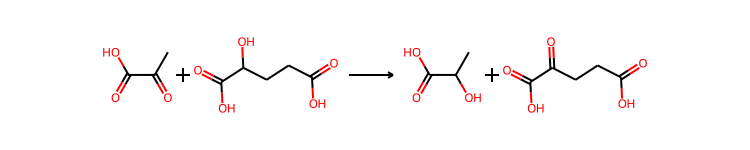

In [9]:
AllChem.ReactionFromSmarts(path_rxns[0], useSmiles=True)

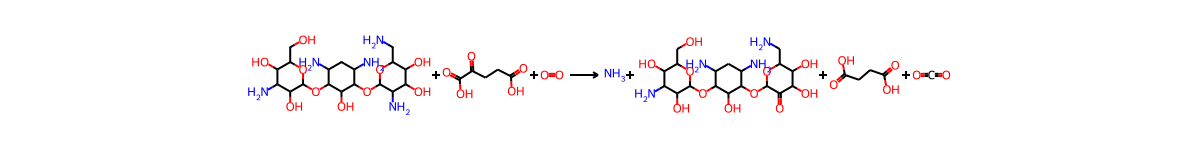

In [10]:
AllChem.ReactionFromSmarts(path_rxns[1], useSmiles=True)

Look at "frustration" in reactant product alignment

In [17]:
# Construct sim mats based on correlated appearance in reactions

cpd_corr = np.zeros(shape=(len(known_compounds), len(known_compounds)))
for rid, rxn in known_reactions.items():
    lhs, rhs = [set(side.split(".")) for side in rxn['smarts'].split(">>")] # Set out stoichiometric degeneracy
    for pair in product(lhs, rhs):
        i, j = [smi2id[elt] for elt in pair]
        if i == 2 and j == 2:
            print(rid)
        cpd_corr[i, j] += 1
        cpd_corr[j, i] += 1
    
row_sum = cpd_corr.sum(axis=1).reshape(-1, 1)
col_sum = cpd_corr.sum(axis=0).reshape(1, -1)
cpd_jaccard = cpd_corr / (row_sum + col_sum - cpd_corr) # Jaccard co-occurence-in-rxn index. Symmetric
cond_prob = cpd_corr / row_sum # elt (i, j) gives P(cpd_j | cpd_i). NOT symmetric

# Construct sim mats based on molecular structure
mfper = MorganFingerPrinter()
tani_sim_mat = np.zeros(shape=(len(known_compounds), len(known_compounds)))
for i in range(len(known_compounds) - 1):
    mol_i = Chem.MolFromSmiles(known_compounds[i]['smiles'])
    mfp_i = mfper.fingerprint(mol_i)
    for j in range(i + 1, len(known_compounds)):
        mol_j = Chem.MolFromSmiles(known_compounds[j]['smiles'])
        mfp_j = mfper.fingerprint(mol_j)
        ts = tanimoto_similarity(mfp_i, mfp_j)
        tani_sim_mat[i, j] = ts
        tani_sim_mat[j, i] = ts

[09:47:11] WARNING: not removing hydrogen atom with dummy atom neighbors
[09:47:11] WARNING: not removing hydrogen atom with dummy atom neighbors
[09:47:13] WARNING: not removing hydrogen atom with dummy atom neighbors
[09:47:19] Unusual charge on atom 0 number of radical electrons set to zero
[09:47:20] Unusual charge on atom 0 number of radical electrons set to zero
[09:47:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[09:47:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[09:47:25] WARNING: not removing hydrogen atom with dummy atom neighbors
[09:47:31] Unusual charge on atom 0 number of radical electrons set to zero
[09:47:32] Unusual charge on atom 0 number of radical electrons set to zero
[09:47:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[09:47:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[09:47:37] WARNING: not removing hydrogen atom with dummy atom neighbors
[09:47:44] Unusual charge on atom 0 num

KeyboardInterrupt: 

In [16]:
mfp_i, mfp_j

(array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]))

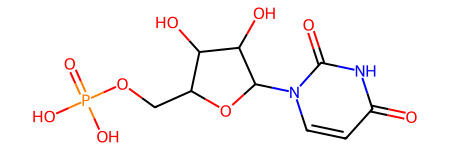

In [15]:
mol_i

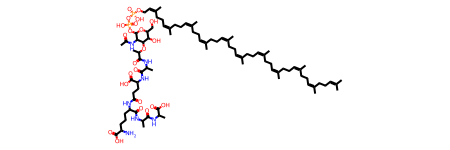

In [16]:
mol_j

In [72]:
def is_cofactor(smiles: str, cofactors: dict[str, str]):
    if smiles in cofactors:
        return True
    else:
        return False


rxn_tani_mats = {}
rxn_corr_mats = {}
frustrated = []
side_counts = defaultdict(set)
for rid, rxn in known_reactions.items():
    lhs, rhs = [set(side.split(".")) for side in rxn['smarts'].split(">>")] # Set out stoichiometric degeneracy
    lhs = [elt for elt in lhs if elt not in cofactors]
    rhs = [elt for elt in rhs if elt not in cofactors]

    if not lhs or not rhs:
        continue

    left_ids, right_ids = np.array([smi2id[smi] for smi in lhs]), np.array([smi2id[smi] for smi in rhs])
    left_names, right_names = [known_compounds[id]['name'] for id in left_ids], [known_compounds[id]['name'] for id in right_ids]
    i, j = np.array(list(zip(*product(left_ids, right_ids))))

    corr_data = cpd_jaccard[i, j].reshape(len(left_ids), len(right_ids))
    tani_data = tani_sim_mat[i, j].reshape(len(left_ids), len(right_ids))
    
    corr_df = pd.DataFrame(data=corr_data, columns=right_names, index=left_names)
    tani_df = pd.DataFrame(data=tani_data, columns=right_names, index=left_names)

    rxn_corr_mats[rid] = corr_df
    rxn_tani_mats[rid] = tani_df

    side_counts[tuple(sorted([len(x) for x in [lhs, rhs]]))].add(rid)

In [73]:
rxn_corr_mats[0]

,L-glutamyl 5-phosphate
L-glutamate 5-semialdehyde,0.058824


In [74]:
sorted([(k, len(v)) for k,v in side_counts.items()], key= lambda x : x[1], reverse=True)

[((1, 1), 4442),
 ((1, 2), 2613),
 ((2, 2), 2365),
 ((2, 3), 149),
 ((1, 3), 33),
 ((3, 3), 29),
 ((3, 4), 14),
 ((2, 4), 11),
 ((3, 5), 9),
 ((2, 5), 3),
 ((4, 6), 3),
 ((4, 5), 2),
 ((4, 4), 2),
 ((5, 6), 1)]

In [104]:
side_counts[(2,3)]

{71,
 111,
 123,
 344,
 358,
 374,
 536,
 574,
 607,
 737,
 815,
 916,
 1276,
 1289,
 1623,
 1662,
 1897,
 1973,
 2029,
 2031,
 2047,
 2065,
 2114,
 2200,
 2258,
 2331,
 2437,
 2504,
 2559,
 2620,
 2803,
 2818,
 2870,
 2878,
 2888,
 3057,
 3242,
 3267,
 3552,
 3615,
 3648,
 3695,
 3836,
 3957,
 4082,
 4286,
 4288,
 4299,
 4331,
 4388,
 4485,
 4494,
 4521,
 4523,
 5218,
 5519,
 5559,
 5574,
 5680,
 6311,
 6536,
 6623,
 6652,
 6677,
 6687,
 6713,
 6741,
 6985,
 7044,
 7218,
 7322,
 7483,
 7610,
 7923,
 7961,
 7968,
 7983,
 8204,
 8242,
 8268,
 8298,
 8430,
 8564,
 8632,
 8644,
 8662,
 8730,
 8883,
 9072,
 9153,
 9273,
 9357,
 9391,
 9404,
 9492,
 9633,
 9766,
 9803,
 10106,
 10202,
 10245,
 10300,
 10452,
 10486,
 10704,
 10904,
 11062,
 11083,
 11086,
 11209,
 11327,
 11467,
 11685,
 11926,
 11993,
 12028,
 12316,
 12466,
 12494,
 12896,
 12927,
 12954,
 13357,
 13675,
 13751,
 13837,
 13945,
 14002,
 14269,
 14468,
 14581,
 14599,
 14611,
 14640,
 14740,
 14931,
 15315,
 15330,
 15383,

In [107]:
eg = 358
rxn_corr_mats[eg]

,S-adenosyl-L-methionine,O-(S-fatty acylpantetheine-4'-phosphoryl)-L-serine residue
S-methyl-5'-thioadenosine,0.010400,0.010989
O-(pantetheine-4'-phosphoryl)-L-serine residue,0.001911,0.038760
an N-acyl-L-homoserine lactone,0.000820,0.020408


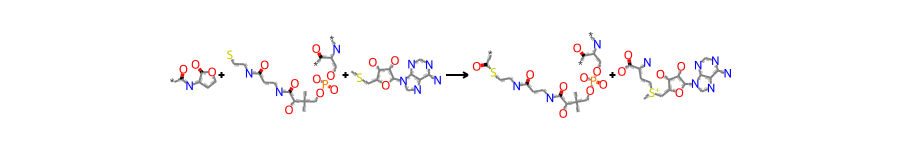

In [108]:
AllChem.ReactionFromSmarts(known_reactions[eg]['smarts'])

In [110]:
def get_mfp(
        mol: rdkit.Chem.rdchem.Mol,
        radius: int = 2,
        length: int = 2**10,
        use_features: bool = False,
        use_chirality: bool = False,
    ):
    vec = AllChem.GetMorganFingerprintAsBitVect(
        mol,
        radius=radius,
        nBits=length,
        useFeatures=use_features,
        useChirality=use_chirality,
    )
    return vec

np.array(get_mfp(Chem.MolFromSmiles("CCO")))

[16:55:37] DEPRECATION WARNING: please use MorganGenerator


array([0, 0, 0, ..., 0, 0, 0])

In [120]:

mfper = MorganFingerPrinter()
mfper.fingerprint(Chem.MolFromSmiles("CCO")).dtype

dtype('int64')

In [103]:
known_reactions[eg]['rhea_ids']

[45141]

In [27]:
{k: v for k,v in known_reactions.items() if '2-oxoglutarate' in v['smi2name'].values()}

{12447: {'smarts': 'NCC1OC(OC2C(N)CC(N)C(OC3OC(CO)C(O)C(N)C3O)C2O)C(N)C(O)C1O.O=C(O)CCC(=O)C(=O)O.O=O>>N.NCC1OC(OC2C(N)CC(N)C(OC3OC(CO)C(O)C(N)C3O)C2O)C(=O)C(O)C1O.O=C(O)CCC(=O)O.O=C=O',
  'min_rule': None,
  'imt_rules': None,
  'smi2name': {'NCC1OC(OC2C(N)CC(N)C(OC3OC(CO)C(O)C(N)C3O)C2O)C(N)C(O)C1O': 'kanamycin B',
   'O=C(O)CCC(=O)C(=O)O': '2-oxoglutarate',
   'O=O': 'O2',
   'N': 'NH4(+)',
   'NCC1OC(OC2C(N)CC(N)C(OC3OC(CO)C(O)C(N)C3O)C2O)C(=O)C(O)C1O': "2'-dehydrokanamycin A",
   'O=C(O)CCC(=O)O': 'succinate',
   'O=C=O': 'CO2'},
  'enzymes': [{'uniprot_id': 'Q6L732',
    'sequence': 'MALAAPPGELTLALTPDDKTLDPASLDRALAILAEHGILVLTGMLRTRLTDQLRTAMLDDLPEVLRQQDVPTNFVPGHVQQDPPVRESLLFPDVLLNPVVYQITHAVLGADARNAVYSGNMNLPGSHEQPVHLDEPHLWPGISHPPYCLCVDVPLIDFTLENGSTEYWPGSHVLNPDECYDERGCVLPAELERRRAVAPPVRFPIPVGSVVIRDGRLWHRGVPNLSAAPRPLLAMTHYTEWFDMPPIQLPDTVKSWVDGSDRHTHAHFVAGDVDHLTGDHPFAVR',
    'existence': 'Evidence at protein level',
    'reviewed': 'reviewed',
    'ec': '1.14.11.37',
    'organism': '

In [94]:
print(len(known_reactions))

9801
